In [1]:
import random
import networkx as nx
import torch

from deep_ebm.utils_ebm import show_graph, evaluate_model
from deep_ebm.utils_ebm import save_graph, compare_graphs, show_graph_grid, compare_statistics
from deep_ebm.gnn_ebm import GraphDataset, GNN_EBM, train_one_epoch_pcd, gibbs_ministeps

from Plots_and_utils.plots import *
import pickle as pkl

device = torch.device("cpu")

---

In [2]:
with open("data/2community_dataset/2comms_GraphDataset.pkl", "rb") as f:
    dataset_2community  = pkl.load(f)

with open("Saved_models/2community_GNN_EBM_50epochs.pkl", "rb") as f:
    model_2community = pkl.load(f)

In [10]:
metrics10 = evaluate_model(model_2community, dataset_2community, device, num_graphs = 1000, gibbs_steps=10)
metrics100 = evaluate_model(model_2community, dataset_2community, device, num_graphs = 1000, gibbs_steps=100)
metrics500 = evaluate_model(model_2community, dataset_2community, device, num_graphs = 1000, gibbs_steps=500)
metrics1000 = evaluate_model(model_2community, dataset_2community, device, num_graphs = 1000, gibbs_steps=1000)

In [12]:
print("Metrics after 10 Gibbs steps:", metrics10)
print("Metrics after 100 Gibbs steps:", metrics100)
print("Metrics after 500 Gibbs steps:", metrics500)
print("Metrics after 1000 Gibbs steps:", metrics1000)


Metrics after 10 Gibbs steps: {'degree_mmd': 0.009233494948541117, 'clustering_mmd': 0.0024829378234605404}
Metrics after 100 Gibbs steps: {'degree_mmd': 0.010221076951830695, 'clustering_mmd': 0.06007352623257223}
Metrics after 500 Gibbs steps: {'degree_mmd': 0.01022794647467346, 'clustering_mmd': 0.09500600396632852}
Metrics after 1000 Gibbs steps: {'degree_mmd': 0.010215617589459368, 'clustering_mmd': 0.07487308277407889}


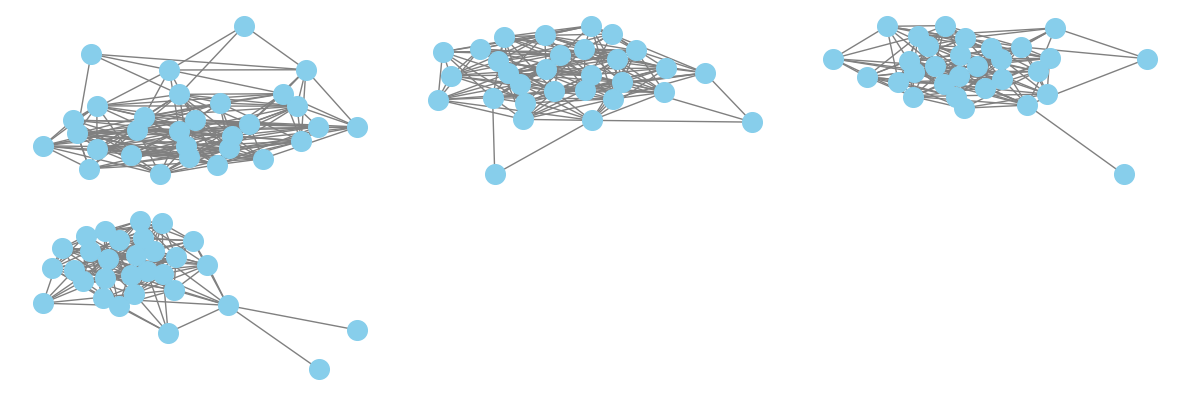

=== Graph Statistics Comparison ===
Real graphs: 200 graphs
  Avg nodes:      30.00
  Avg edges:      132.10
  Avg degree:     8.81
  Avg clustering: 0.479
Generated graphs: 4 graphs
  Avg nodes:      30.00
  Avg edges:      173.00
  Avg degree:     11.53
  Avg clustering: 0.416


({'num_graphs': 200,
  'avg_nodes': np.float64(30.0),
  'avg_edges': np.float64(132.1),
  'avg_degree': np.float64(8.806666666666667),
  'avg_clustering': np.float64(0.47923333702617754),
  'avg_algebraic_connectivity': np.float64(0.1101877506253583)},
 {'num_graphs': 4,
  'avg_nodes': np.float64(30.0),
  'avg_edges': np.float64(173.0),
  'avg_degree': np.float64(11.533333333333331),
  'avg_clustering': np.float64(0.41626335366273454),
  'avg_algebraic_connectivity': np.float64(1.5378931204068234)})

In [ ]:
generated = []
with torch.no_grad():
    for i in range(4):
        A, feats = dataset_2community[i]
        A_gen = gibbs_ministeps(A, model_2community, feats.to(device), device, mini_steps=10000)
        G_gen = nx.from_numpy_array(A_gen.cpu().numpy())
        generated.append(G_gen) 

show_graph_grid(generated, rows=3, cols=3, layout="spring")

compare_statistics(dataset_2community.graphs, generated)


In [14]:
c = 0
for g in generated:
    if not nx.is_connected(g):
        c += 1

print(f"Number of disconnected generated graphs: {c} over {len(generated)} generated graphs")


Number of disconnected generated graphs: 5 over 200 generated graphs


In [21]:
tmp_dataset = GraphDataset(generated)
energies = []
for g in tmp_dataset:
    feats = g[1]
    adj = g[0]

    energies.append(model_2community(feats, adj))
 

In [22]:
energies

[tensor(5865.5220, grad_fn=<SqueezeBackward0>),
 tensor(5865.3247, grad_fn=<SqueezeBackward0>),
 tensor(5866.1831, grad_fn=<SqueezeBackward0>),
 tensor(5875.2651, grad_fn=<SqueezeBackward0>)]